# Movie Recommender System, part I: Initial Data Exploration
### Robert Chen, B20-AI
-----------------------------------------

## Step 0: Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import os
import matplotlib.pyplot as plt

## Step 1: Downloading MovieLens-100k Dataset

In [3]:
!bash ../data/raw/download_ml100k.sh

data_folder = os.path.join('..', 'data', 'raw', 'ml-100k')
print(data_folder)

File ‘/home/b0b/Personal/Uni/InnoStuff/F23/Practical Machine Learning/Recommender System/data/raw/ml-100k.zip’ already there; not retrieving.

Archive:  /home/b0b/Personal/Uni/InnoStuff/F23/Practical Machine Learning/Recommender System/data/raw/ml-100k.zip
../data/raw/ml-100k


## Step 2: Cleaning Up the Dataset

First of all, let us take a look at overall statistics:

In [4]:
stats = pd.read_csv(os.path.join(data_folder, 'u.info'), sep='\t', header=None)
print(', '.join(list(stats[0])))

943 users, 1682 items, 100000 ratings


All review data submitted by users is located in `u.data` file. This table contains information about review score, timestamp of the review and ID tokens to ensure the relation between the tables:

In [5]:
col_names = ['user_id', 'movie_id', 'score', 'timestamp']
reviews = pd.read_csv(os.path.join(data_folder, 'u.data'), sep='\t', header=None, names=col_names)
reviews.head()

,user_id,movie_id,score,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Information regarding the movies is contained in `u.item` file. To get annotations for genres, we will refer to `u.genre` table. We can parse the remaining columns according to official `README`:

In [6]:
genres = pd.read_csv(os.path.join(data_folder, 'u.genre'), sep='|', header=None)
col_names = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url'] + list(genres.iloc[:, 0])
' | '.join(col_names)

"movie_id | movie_title | release_date | video_release_date | imdb_url | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western"

Now, we can parse movie data:

In [7]:
movies = pd.read_csv(os.path.join(data_folder, 'u.item'), sep='|', header=None, names=col_names, encoding='latin-1')
movies.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


All we need for now is a title and a movie ID:

In [8]:
movies_short = movies[['movie_id', 'movie_title']]
movies_short.head()

,movie_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Merging two tables yields:

In [9]:
merged = pd.merge(reviews, movies_short, how='inner', on='movie_id')
merged.head()

,user_id,movie_id,score,timestamp,movie_title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


However, there are some cases when a user rated the same movie multiple times. For instance:

In [10]:
merged[(merged['movie_title'] == 'Chasing Amy (1997)') & (merged['user_id'] == 894)]

,user_id,movie_id,score,timestamp,movie_title
4800,894,246,4,882404137,Chasing Amy (1997)
22340,894,268,3,879896041,Chasing Amy (1997)


We will simply solve it by aggregating the scores by mean value:

In [11]:
updated = merged.groupby(['user_id', 'movie_title'], as_index=False).agg({'score':'mean'})
updated.head()

,user_id,movie_title,score
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


## Step 3: Exploratory Data Analysis

### Score distribution

As a starting point, we can analyze the score distribution for the reviews:

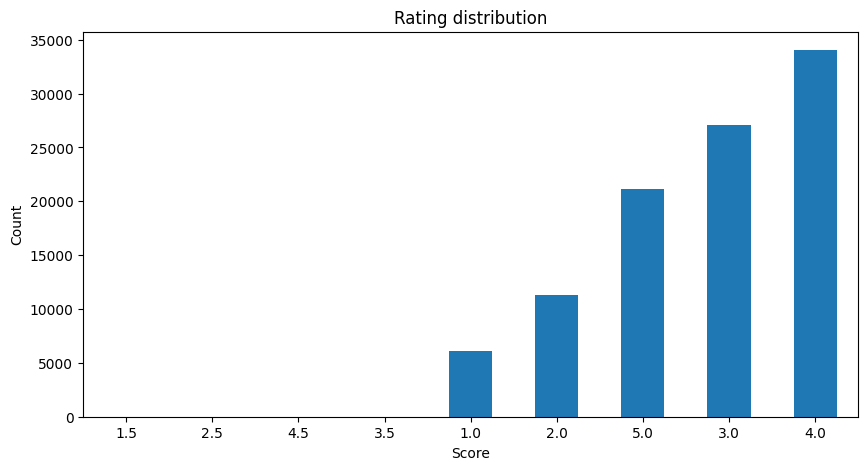

In [14]:
updated['score'].value_counts(sort=True, ascending=True).plot(kind='bar', figsize=(10, 5), use_index=True, rot=0)
plt.title('Rating distribution')
plt.xlabel('Score')
plt.ylabel('Count') 
plt.show()

In [13]:
updated.describe()

,user_id,score
count,99693.000000,99693.000000
mean,462.513366,3.529907
std,266.619991,1.125492
min,1.000000,1.000000
25%,254.000000,3.000000
50%,447.000000,4.000000
75%,682.000000,4.000000
max,943.000000,5.000000


### Genre distribution

Also, it could be useful to know genre distribution of the movies:

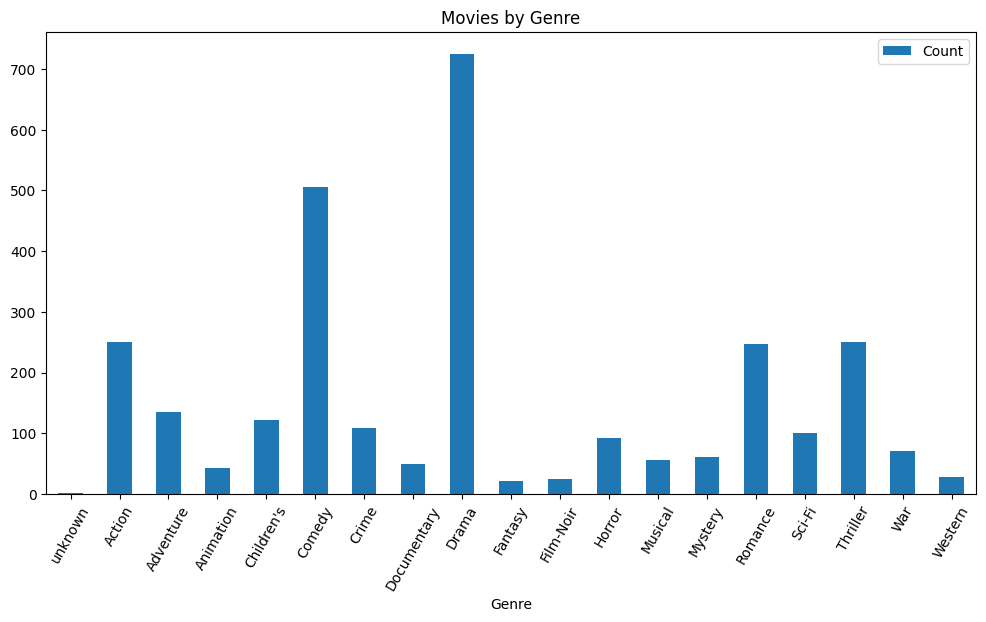

In [17]:
count = []
for i in list(genres.iloc[:, 0]):
    movies_by_genre = movies[['movie_id', 'movie_title', i]]
    count.append(len(movies_by_genre[movies_by_genre[i] == 1]))
temp_df = pd.DataFrame({'Genre': list(genres.iloc[:, 0]), 'Count': count})
temp_df.plot(kind='bar', x='Genre', y='Count', rot=60, figsize=(12, 6))
plt.title('Movies by Genre')
plt.show()

### Most viewed movies

We can also find the most viewed movies in the dataset, it may be very helpful to understand the general sentiment of viewers:

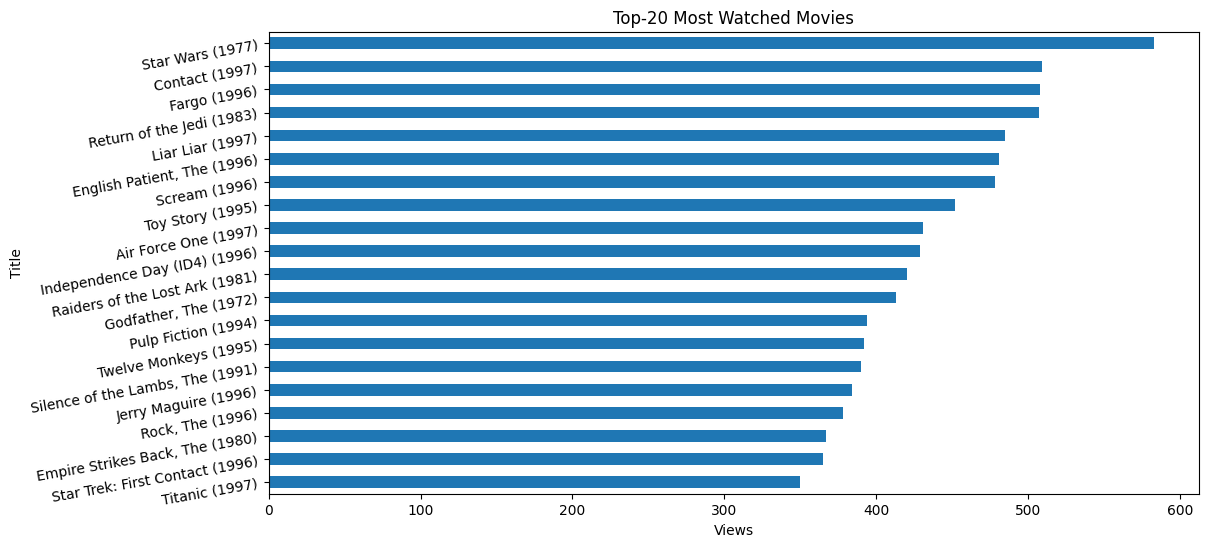

In [28]:
top_20 = updated['movie_title'].value_counts(sort=True, ascending=False)[:20]
ax = top_20.plot(kind='barh', figsize=(12, 6), use_index=True, rot=10, y='movie_title')
ax.invert_yaxis()
plt.title('Top-20 Most Watched Movies')
plt.ylabel('Title')
plt.xlabel('Views')
plt.show()